<center>
<h1>Predicción de series temporales con RNNs</h1>
<h2>Emilio Pomares Porras @emiliothehuman</h2>
    </center>
<br><img src="http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg">
<br><br>Usaremos una RNN para predecir el precio del crudo

In [1]:
# Imports varios...

import tensorflow as tf
import tensorflow.contrib.keras as keras
from tensorflow.keras.models import Sequential
L = keras.layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Carguemos el dataset de precios del petróleo (1986 - 2018). La popular librería <b>Pandas</b> permite leer archivos Excel, así que menos trabajo para nosotros:

In [2]:
xlsData = pd.ExcelFile('Crude Oil Prices Daily.xlsx')

Los datos están en la primera hoja:

In [3]:
pandasData = xlsData.parse(0)

Vistazo a los datos (Dataframe de Pandas):

In [4]:
pandasData

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
5,1986-01-09,26.03
6,1986-01-10,25.65
7,1986-01-13,25.08
8,1986-01-14,24.97
9,1986-01-15,25.18


Para simplificar, consideraremos que los precios son diarios y los puntos de datos son equiespaciados (una auténtica serie temporal). Ignoremos las fechas y conservemos sólo la secuencia de precios:

In [5]:
values = np.array(pandasData["Closing Value"])

Vistazo a los valores:

In [6]:
values

array([25.56, 26.  , 26.53, ..., 73.05, 73.78, 73.93])

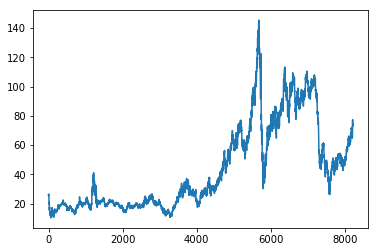

In [7]:
plt.plot(values)

El pico de precio máximo corresponde a finales del año 2008. Definamos un par de funciones que nos ayudarán a preparar nuestro dataset de entrenamiento:

In [8]:
def MakeSequenceWindow(data, start, N=10):
    return (data[start:start+N], data[start+N])

Así que un datapoint (secuencia) -> valor siguiente quedaría así:

In [9]:
MakeSequenceWindow(values, 0, 10)

(array([25.56, 26.  , 26.53, 25.85, 25.87, 26.03, 25.65, 25.08, 24.97,
        25.18]), 23.98)

In [10]:
def MakeTrainingSet(data, nDataPoints, N=10):
    x = []
    y = []
    for i in range (0,nDataPoints):
        dp = MakeSequenceWindow(data, i, N)
        x.append(dp[0])
        y.append(dp[1])
    return ((np.array(x).reshape(nDataPoints, N, 1)), np.array(y).reshape(nDataPoints, 1))

Cuidado que nDataPoints + N sea menor que 8223, o nos salimos de rango

In [22]:
SequenceLength = 30
(allx, ally) = MakeTrainingSet(values, 8000, SequenceLength)
trainx = allx[0:7000]
trainy = ally[0:7000]
valx = allx[7000:8000]
valy = ally[7000:8000]

In [23]:
print(trainx.shape)
print(trainy.shape)

(7000, 30, 1)
(7000, 1)


Estamos en disposición de construir nuestra red RNN. Usaremos unidades GRU en este caso:

In [13]:
HiddenUnits = 10
model = Sequential()
model.add(L.GRU(HiddenUnits, input_shape=(SequenceLength,1), return_sequences=False))
model.add(L.Dense(1))

In [14]:
model.compile('adam', 'mean_squared_error', metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10)                360       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Definamos una clase descendiente de Callback para almacenar una historia de losses

class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            
        def on_epoch_end(self, epoch, logs={}):
            self.losses.append(logs.get('loss'))
            
l = LossHistory()

Entrenemos un poco la red para asegurarnos de que el loss desciende. No nos preocupamos de dar datos de validación en este punto:

In [17]:
nEpochs = 10
model.fit(trainx, trainy, epochs=nEpochs, callbacks=[l])

Epoch 1/10
7000/7000 [==============================] - 7s 965us/step - loss: 2466.0149 - acc: 0.0000e+00
Epoch 2/10
7000/7000 [==============================] - 5s 767us/step - loss: 2206.4897 - acc: 0.0000e+00
Epoch 3/10
7000/7000 [==============================] - 5s 762us/step - loss: 2063.6640 - acc: 0.0000e+00
Epoch 4/10
7000/7000 [==============================] - 5s 778us/step - loss: 1949.3718 - acc: 0.0000e+00
Epoch 5/10
7000/7000 [==============================] - 5s 775us/step - loss: 1845.5834 - acc: 0.0000e+00
Epoch 6/10
7000/7000 [==============================] - 5s 777us/step - loss: 1750.1883 - acc: 0.0000e+00
Epoch 7/10
7000/7000 [==============================] - 5s 775us/step - loss: 1661.9790 - acc: 0.0000e+00
Epoch 8/10
7000/7000 [==============================] - 5s 783us/step - loss: 1580.6329 - acc: 0.0000e+00
Epoch 9/10
7000/7000 [==============================] - 5s 784us/step - loss: 1505.4571 - acc: 0.0000e+00
Epoch 10/10
7000/7000 [=======================

Text(0.5, 1.0, 'Cost function over time (epochs)')

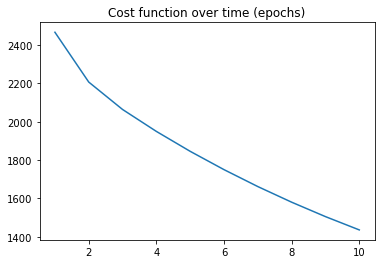

In [18]:
# Echemos un vistazo al coste en función de la época

x = range(1,len(l.losses)+1)
y = l.losses
plt.plot(x,y)
plt.title("Cost function over time (epochs)")

El coste desciende con las iteraciones, y parece que podemos seguir entrenando... hagamos otras 60 épocas:

In [19]:
nEpochs = 60
model.fit(trainx, trainy, epochs=nEpochs, callbacks=[l])

Epoch 1/60
7000/7000 [==============================] - 5s 779us/step - loss: 1372.4779 - acc: 0.0000e+00
Epoch 2/60
7000/7000 [==============================] - 5s 770us/step - loss: 1309.5062 - acc: 0.0000e+00
Epoch 3/60
7000/7000 [==============================] - 5s 784us/step - loss: 1249.2391 - acc: 0.0000e+00
Epoch 4/60
7000/7000 [==============================] - 5s 778us/step - loss: 1192.0094 - acc: 0.0000e+00
Epoch 5/60
7000/7000 [==============================] - 5s 783us/step - loss: 1137.0764 - acc: 0.0000e+00
Epoch 6/60
7000/7000 [==============================] - 5s 767us/step - loss: 1084.2221 - acc: 0.0000e+00
Epoch 7/60
7000/7000 [==============================] - 5s 776us/step - loss: 1033.3555 - acc: 0.0000e+00
Epoch 8/60
7000/7000 [==============================] - 5s 782us/step - loss: 984.4368 - acc: 0.0000e+00
Epoch 9/60
7000/7000 [==============================] - 5s 768us/step - loss: 937.2631 - acc: 0.0000e+00
Epoch 10/60
7000/7000 [=========================

Text(0.5, 1.0, 'Cost function over time (epochs)')

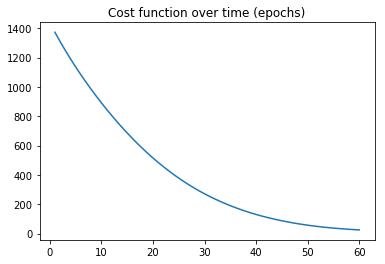

In [20]:
# Echemos otro vistazo al coste en función de la época

x = range(1,len(l.losses)+1)
y = l.losses
plt.plot(x,y)
plt.title("Cost function over time (epochs)")

Hagamos una predicción sobre los datos de validación:

In [25]:
model.predict(valx[0:1])

array([[92.629524]], dtype=float32)

Y el precio que corresponde a ese día es:

In [26]:
valy[0]

array([93.12])

Como vemos, no está demasiado mal